In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import statsmodels.api as sm
import numpy as np

devices = pd.read_csv('../data/Devices.csv')

In [2]:
devices['Activity'].value_counts()

1.Sedentary    45717
0.Sleep        28488
2.Light         2676
3.Moderate      1525
4.Vigorous       180
Name: Activity, dtype: int64

In [3]:
le_activity = LabelEncoder()
le_device = LabelEncoder()
devices['Activity_encoded'] = le_activity.fit_transform(devices['Activity'])
devices['Device_encoded'] = le_device.fit_transform(devices['Device'])


#resampling method
data_maj = devices[devices['Activity'] == '1.Sedentary']
data_min = devices[devices['Activity'] != '1.Sedentary']
data_minsamp = resample(data_min, replace=True, n_samples=len(data_maj), random_state=83)
data_balanced = pd.concat([data_maj, data_minsamp])

#including interaction term
data_balanced['Interaction'] = data_balanced['Device_encoded'] * data_balanced['Activity_encoded']

# Preparing data for regression
X = data_balanced[['Steps', 'Activity_encoded', 'Device_encoded', 'Interaction']]
y = data_balanced['Heart']
X = sm.add_constant(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Fitting OLS regression model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Heart   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        00:50:58   Log-Likelihood:            -2.9995e+05
No. Observations:               73147   AIC:                         5.999e+05
Df Residuals:                   73142   BIC:                         6.000e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               64.9145      0.093  

In [4]:
scorer = make_scorer(mean_squared_error, squared=False)
cv_results = cross_val_score(LinearRegression(), X_train.drop(columns='const'), y_train, cv=10, scoring=scorer)
print(f'Mean RMSE: {np.mean(cv_results)}, Standard Deviation of RMSE: {np.std(cv_results)}')

Mean RMSE: 14.610177391437379, Standard Deviation of RMSE: 0.14559936334309126


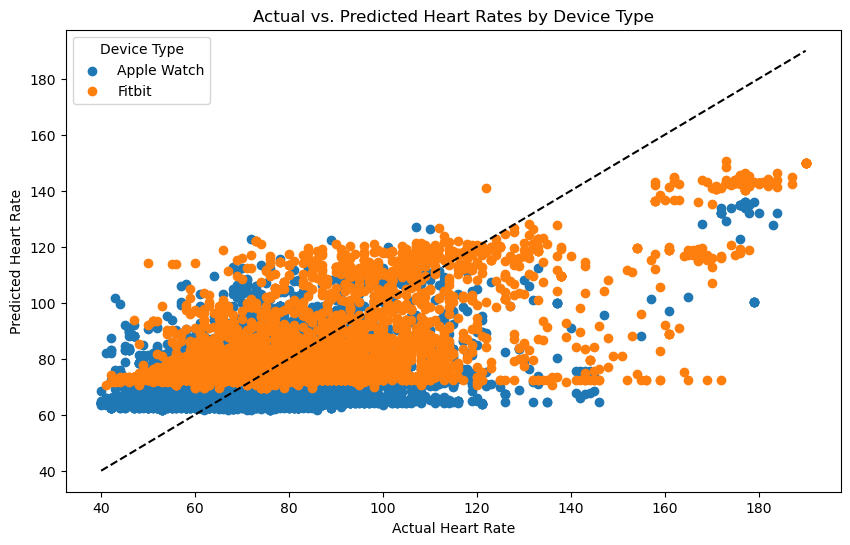

In [5]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)  

# labels for plotting are added
X_test['Device_label'] = le_device.inverse_transform(X_test['Device_encoded'])

# Plotting Actual vs. Predicted Heart Rates by Device Type
plt.figure(figsize=(10, 6))
for device in X_test['Device_label'].unique():
    subset = X_test[X_test['Device_label'] == device]
    plt.scatter(y_test[subset.index], y_pred[subset.index], label=device)

plt.title('Actual vs. Predicted Heart Rates by Device Type')
plt.xlabel('Actual Heart Rate')
plt.ylabel('Predicted Heart Rate')
plt.legend(title='Device Type')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')  # optimal line
plt.show()